In [64]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pickle
import music21
import matplotlib.pyplot as plt

from fractions import Fraction
from collections import defaultdict, Counter
from iteration_utilities import deepflatten #flatten nested lists

from music21 import midi, note, stream, instrument, meter, key
import itertools
import random

import string
import pretty_midi

In [65]:
def moving_average(a, n=3):
    t = np.floor(n/2).astype(int)
    b = np.zeros(len(a))
    for i in range(len(b)):
        b[i] = np.mean(a[max(0,i-t):min(i+t+1,len(a))])
    
    return b

In [66]:
def exp_func(a, l=1):
    b = a * (a > 0)

    return 1 - np.exp(-l*b)

In [67]:
filename = 'Hou06M_annotations.txt'
df = pd.read_csv(filename, sep="\t", header=None)
times = df.iloc[:,0].values
diff = times[1:] - times[:-1]

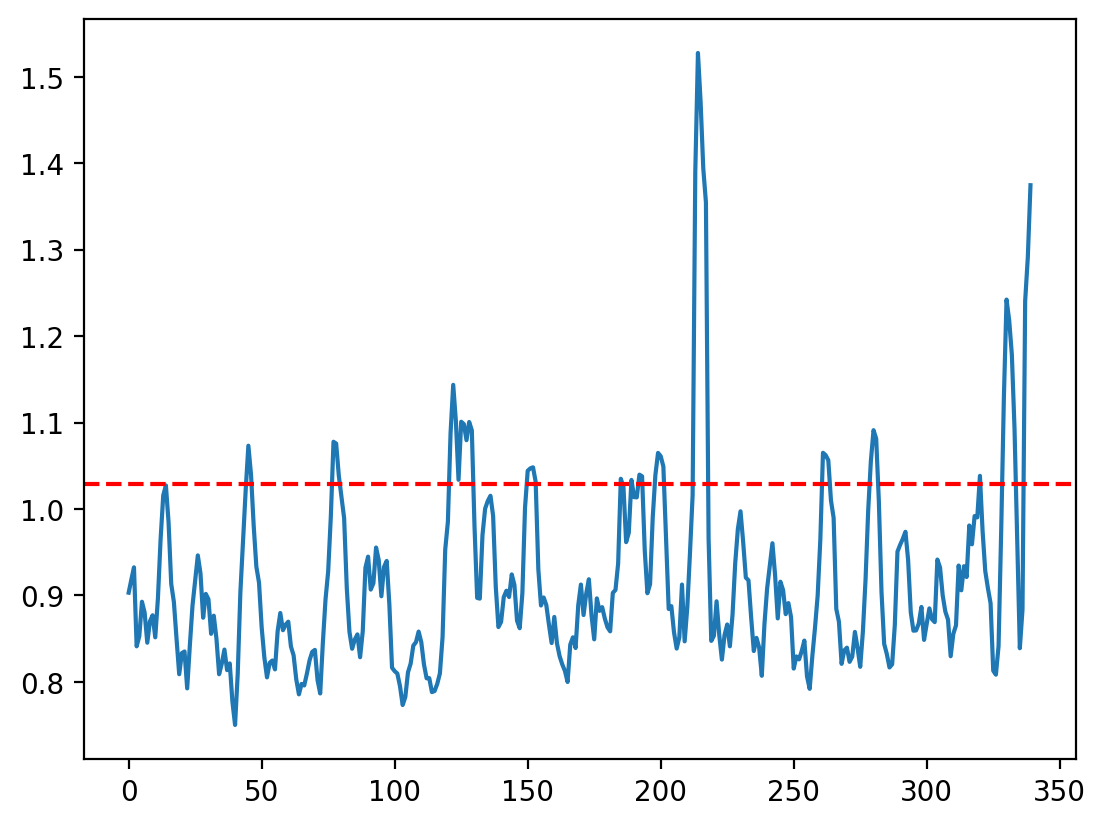

In [68]:
avg_diff = moving_average(diff, n=5)
threshold = np.mean(avg_diff) + np.std(avg_diff)

plt.plot(avg_diff)
plt.axhline(y=threshold, color='r', linestyle='--')

In [78]:
idx = avg_diff > threshold # Candidate breaks
''' Give probability depending on:
    - distance from previous candidate breaks (unlikely htat two breaks are close to each other)
    - distance from threshold (the longer the pause, the more likely it is a phase break) '''
# Probability depending on distance from threshold
prob1 = exp_func(avg_diff - threshold, l=50)

# Probability depending on distance from previous candidate breaks 
# (if there are consecutive candidate breaks, the distance is counted from the first one)
dist = np.zeros(len(idx))
count = 0
for i in range(len(dist)):
    if idx[i] == False:
        dist[i] = 0
        count += 1
    else:
        if idx[i-1] == True:
            dist[i] = 0
            count += 1
        else:
            dist[i] = count
            count = 0
prob2 = exp_func(dist, l=3)

# Final probability estimate
prob = prob1 * prob2

# Selection of final breaks
prob_threshold = 0.8
break_idx = prob > prob_threshold
breaks = times[1:][break_idx]

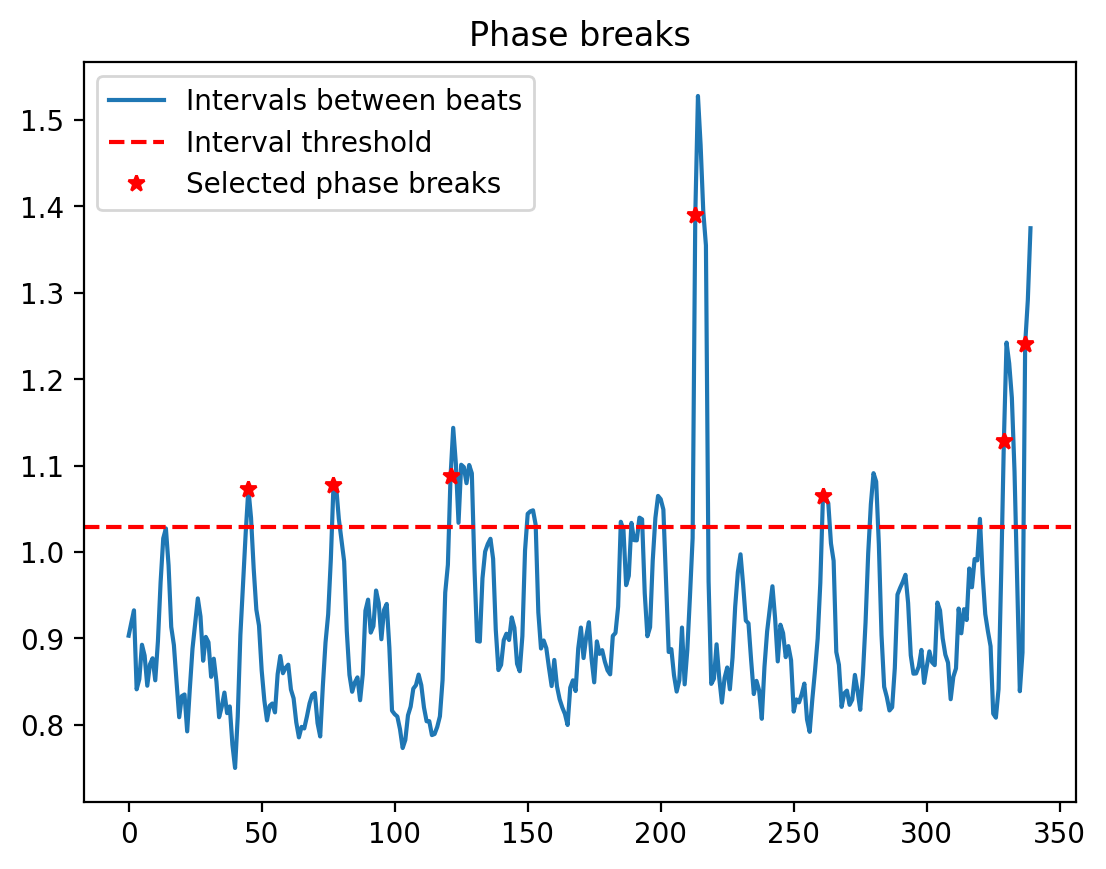

In [87]:
plt.plot(avg_diff, label="Intervals between beats")
plt.axhline(y=threshold, color='r', linestyle='--', label="Interval threshold")
points = np.arange(len(avg_diff))[break_idx]
plt.plot(points, avg_diff[break_idx], 'r*', label="Selected phase breaks")
plt.legend()
plt.title('Phase breaks')
plt.show()